In [1]:
import numpy as np
import sympy
import scipy
from scipy.linalg import lu
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import time
import itertools

## 3.2

### define function

In [2]:
# Classical Gram-Schmidt orthogonalization
def clgs(A):
    m, n = A.shape
    V = A.copy()
    Q = np.eye(m, n)
    R = np.zeros((n, n))
    for j in range(n):
        for i in range(j):
            R[i, j] = np.matmul(Q[:, i:i+1].T, A[:, j:j+1])
            V[:, j:j+1] = V[:, j:j+1] - R[i, j] * Q[:, i:i+1]
        R[j, j] = np.linalg.norm(V[:, j:j+1])
        Q[:, j:j+1] = V[:, j:j+1] / R[j, j]
    return Q, R

In [3]:
# Modified Gram-Schmidt orthogonalization
def mgs(A):
    m, n = A.shape
    Q = A.copy()
    R = np.zeros((n, n))
    for i in range(n-1):
        R[i, i] = np.linalg.norm(Q[:, i:i+1])
        Q[:, i:i+1] /= R[i, i]
        R[i:i+1, i+1:n] = np.matmul(Q[:, i:i+1].T, Q[:, i+1:n])
        Q[:, i+1:n] -= np.matmul(Q[:, i:i+1], R[i:i+1, i+1:n])
    R[n-1, n-1] = np.linalg.norm(Q[:, n-1:n])
    Q[:, n-1:n] /= R[n-1, n-1]
    return Q, R

In [4]:
# Householder QR factorization
def qrhouse(A):
    m, n = A.shape
    R = A.copy()
    V = np.zeros((m, n))
    for k in range(min(m, n)):
        x = R[k:m, k:k+1].copy()
        v = x + np.sign(x[0]) * np.linalg.norm(x) * np.eye(len(x), 1)
        V[k:m, k:k+1] = v
        R[k:m, k:n] = R[k:m, k:n] - np.matmul((2*v), np.matmul(v.T, R[k:m, k:n])) / np.matmul(v.T, v)
    R = np.triu(R[:n, :n])
    return V, R

def formQ(V):
    m, n = V.shape
    Q = np.eye(m)
    for j in range(min(m, n), 0, -1):
        v = V[:, j-1:j].copy()
        Q = Q - np.matmul((2*v), np.matmul(v.T, Q)) / np.matmul(v.T, v)
    return Q

### 3.2.a)

In [5]:
U, X = np.linalg.qr(np.random.randn(80, 80))
V, X = np.linalg.qr(np.random.randn(80, 80))
J = [i for i in range(1, 81)]
S = np.diag(np.array([2**-i for i in J]))
A = np.matmul(np.matmul(U, S), V)

Qc, Rc = clgs(A)
Qm, Rm = mgs(A)

In [6]:
rc_list = [tuple(row) for row in np.stack((J, np.diag(Rc))).T]
rm_list = [tuple(row) for row in np.stack((J, np.diag(Rm))).T]

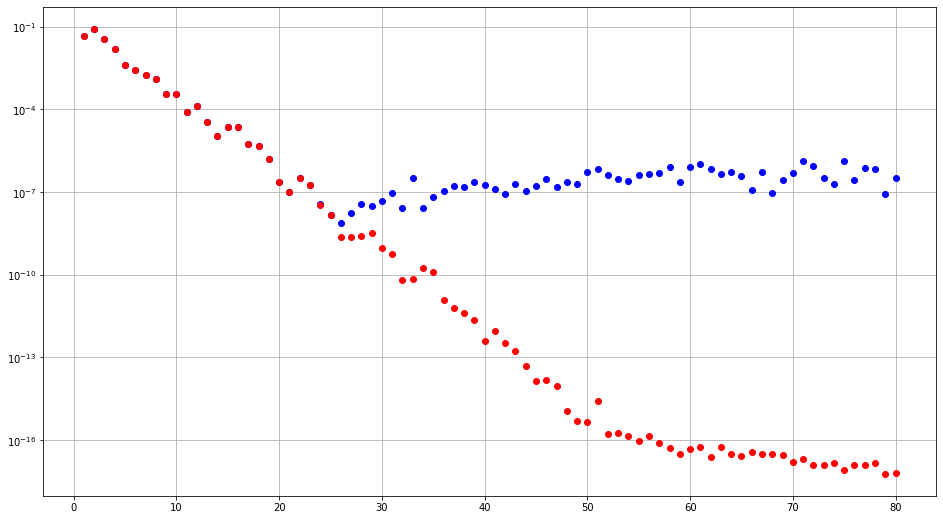

In [55]:
fig, ax = plt.subplots(figsize = (16,9))
plt.yscale(value = 'log')
plt.grid()
for tup in rc_list:
    plt.plot(*tup, 'bo')
for tup in rm_list:
    plt.plot(*tup, 'ro')

### 3.2.b)

In [8]:
A = np.array([[.70000, .70711],
              [.70001, .70711]])
Qm, Rm = mgs(A)
V, R = qrhouse(A)
Q = formQ(V)
Q_norm = np.linalg.norm(np.matmul(Q.T, Q) - np.eye(2))
Qm_norm = np.linalg.norm(np.matmul(Qm.T, Qm) - np.eye(2))

print(Q_norm)
print(Qm_norm)

3.451616545114987e-16
3.254726094493924e-11


householder is more stable

## 3.3

In [9]:
# QR factorization using Givens rotation
def G_rot(i, k, A):
    m, n = A.shape
    x1 = A[k, k]
    x2 = A[i, k]
    cos = x1 / np.linalg.norm((x1, x2))
    sin = x2 / np.linalg.norm((x1, x2))

    G = np.eye(m)
    G[i, i] = cos
    G[k, k] = cos
    G[i, k] = -sin
    G[k, i] = sin

    return np.matmul(G, A), G

def qr_givens(A):
    m, n  = A.shape
    R = A.copy()
    Q = np.eye(m)
    for k in range(n):
        for j in range(n-k-1):
            i = m - j - 1
            R, G = G_rot(i, k, R)
            Q = np.matmul(Q, G.T)
    return Q, R
    

In [124]:
# test
A = np.array([[1, 2, 3, 4],
              [4, 5, 6, 2],
              [2, 7, 4, 5],
              [6, 3, 5, 1]])

In [125]:
q, r = qr_givens(A)
print(q)
print()
print(r)

[[ 0.13245324  0.1758246   0.73002548  0.64699664]
 [ 0.52981294  0.20219829  0.46044091 -0.6829409 ]
 [ 0.26490647  0.85274931 -0.41272682  0.17972129]
 [ 0.79471941 -0.44835273 -0.29105591  0.28755406]]

[[ 7.54983444e+00  7.15247473e+00  8.60946032e+00  3.70869060e+00]
 [ 0.00000000e+00  5.98682765e+00  2.90989714e+00  4.92308881e+00]
 [ 0.00000000e+00  6.99290679e-17  1.84653503e+00  1.48629370e+00]
 [ 0.00000000e+00 -3.12207927e-17 -1.93324780e-17  2.40826527e+00]]


In [126]:
np.matmul(q, r)

array([[1., 2., 3., 4.],
       [4., 5., 6., 2.],
       [2., 7., 4., 5.],
       [6., 3., 5., 1.]])

In [127]:
# 검증
q, r = np.linalg.qr(A)

In [128]:
q

array([[-0.13245324, -0.1758246 ,  0.73002548, -0.64699664],
       [-0.52981294, -0.20219829,  0.46044091,  0.6829409 ],
       [-0.26490647, -0.85274931, -0.41272682, -0.17972129],
       [-0.79471941,  0.44835273, -0.29105591, -0.28755406]])

In [130]:
r

array([[-7.54983444, -7.15247473, -8.60946032, -3.7086906 ],
       [ 0.        , -5.98682765, -2.90989714, -4.92308881],
       [ 0.        ,  0.        ,  1.84653503,  1.4862937 ],
       [ 0.        ,  0.        ,  0.        , -2.40826527]])

In [131]:
np.matmul(q, r)

array([[1., 2., 3., 4.],
       [4., 5., 6., 2.],
       [2., 7., 4., 5.],
       [6., 3., 5., 1.]])

## 4.3

### 4.3.a)

In [58]:
np.random.seed(42)

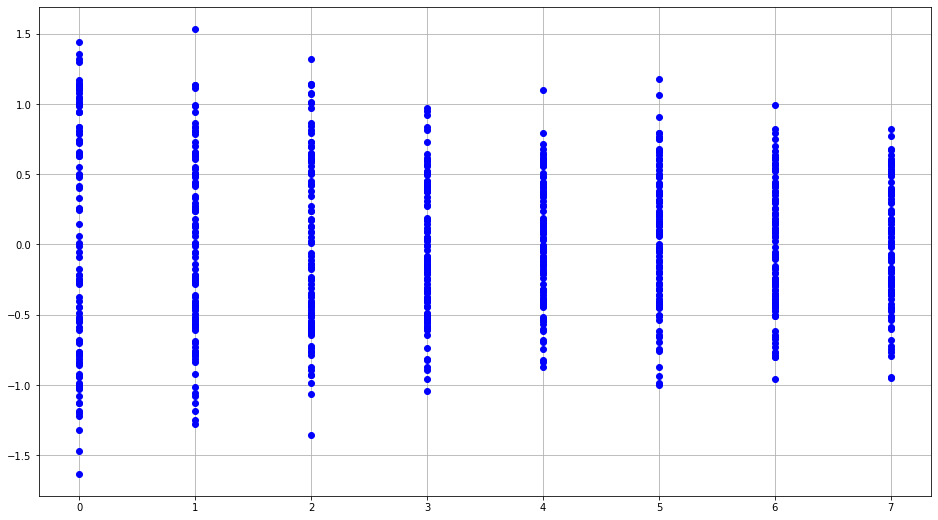

In [103]:
fig, ax = plt.subplots(figsize = (16,9))
plt.grid()

m = 8

for i in range(100):
    A = np.random.randn(m, m) / np.sqrt(m)
    plt.plot(np.real(np.linalg.eigvals(A)), 'bo')

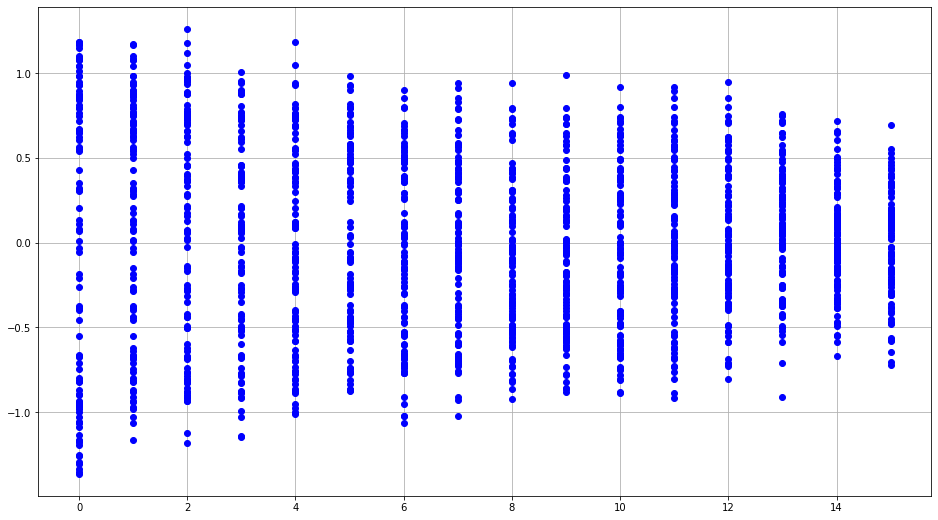

In [104]:
fig, ax = plt.subplots(figsize = (16,9))
plt.grid()

m = 16

for i in range(100):
    A = np.random.randn(m, m) / np.sqrt(m)
    plt.plot(np.real(np.linalg.eigvals(A)), 'bo')

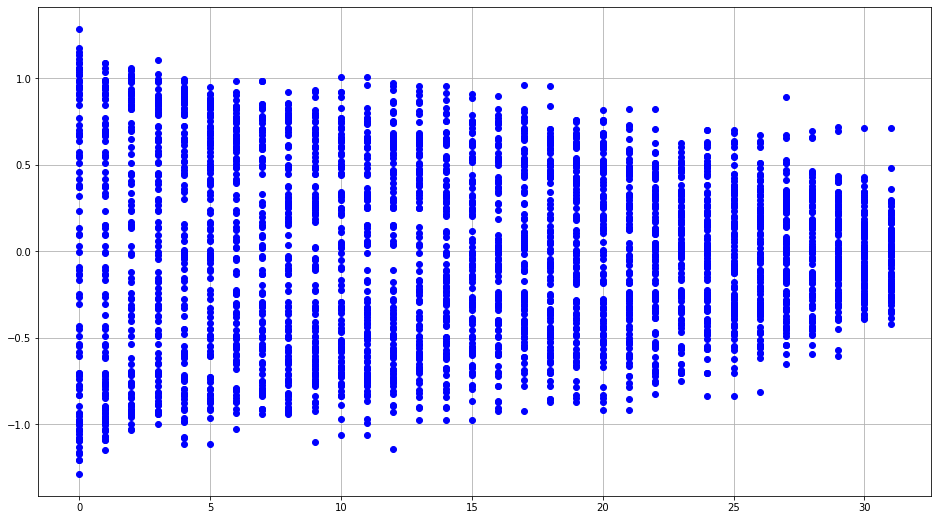

In [105]:
fig, ax = plt.subplots(figsize = (16,9))
plt.grid()

m = 32

for i in range(100):
    A = np.random.randn(m, m) / np.sqrt(m)
    plt.plot(np.real(np.linalg.eigvals(A)), 'bo')

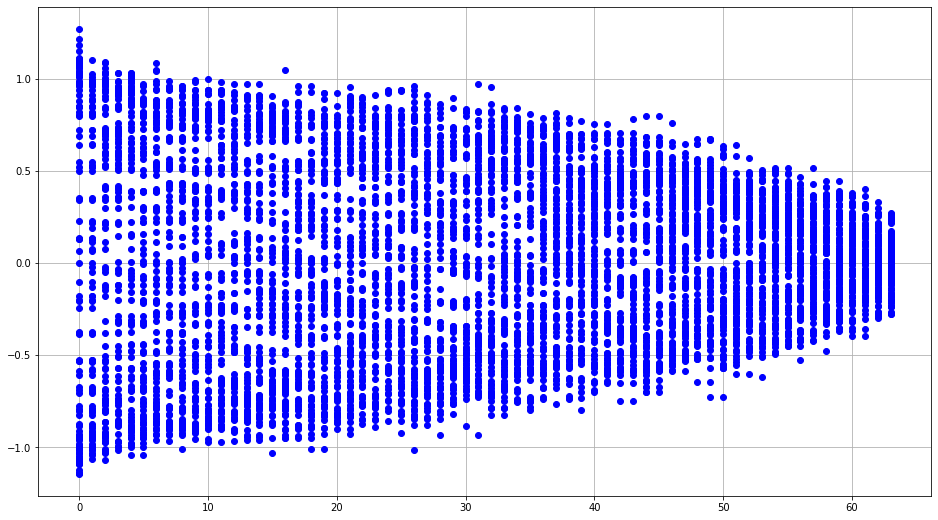

In [106]:
fig, ax = plt.subplots(figsize = (16,9))
plt.grid()

m = 64

for i in range(100):
    A = np.random.randn(m, m) / np.sqrt(m)
    plt.plot(np.real(np.linalg.eigvals(A)), 'bo')

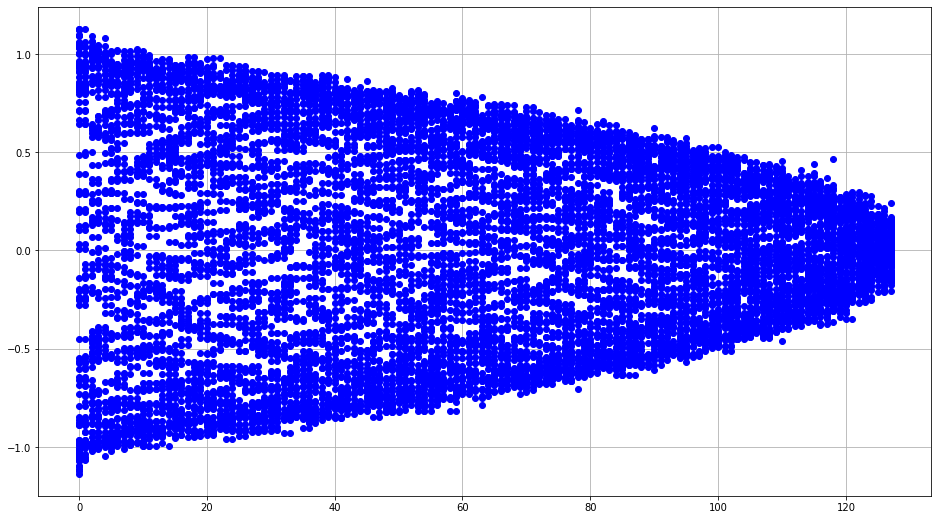

In [107]:
fig, ax = plt.subplots(figsize = (16,9))
plt.grid()

m = 128

for i in range(100):
    A = np.random.randn(m, m) / np.sqrt(m)
    plt.plot(np.real(np.linalg.eigvals(A)), 'bo')

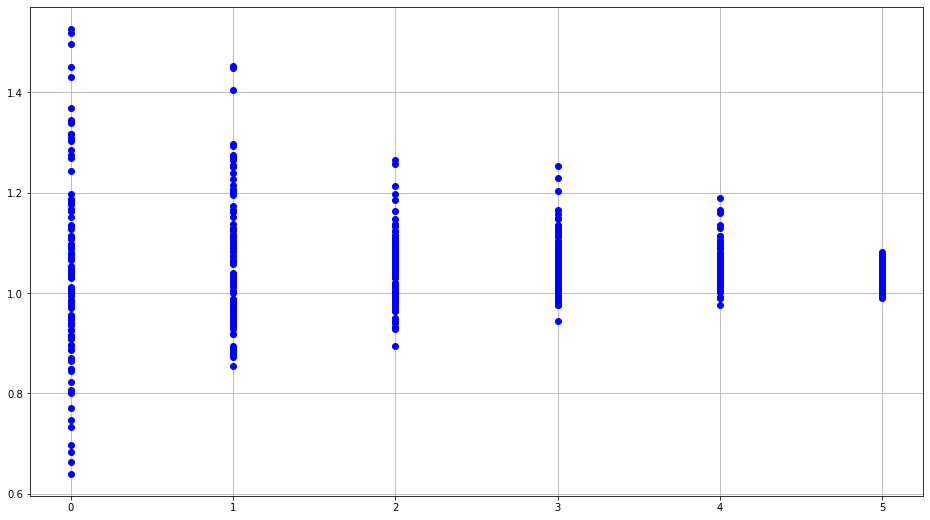

In [113]:
rad_list = []
for m in [8, 16, 32, 64, 128, 256]:
    temp_list = []
    for i in range(100):
        A = np.random.randn(m, m) / np.sqrt(m)
        temp_list.append(max(np.abs(np.linalg.eigvals(A))))
    rad_list.append(temp_list)

fig, ax = plt.subplots(figsize = (16,9))
plt.grid()
plt.plot(rad_list, 'bo')

### 4.3.b)

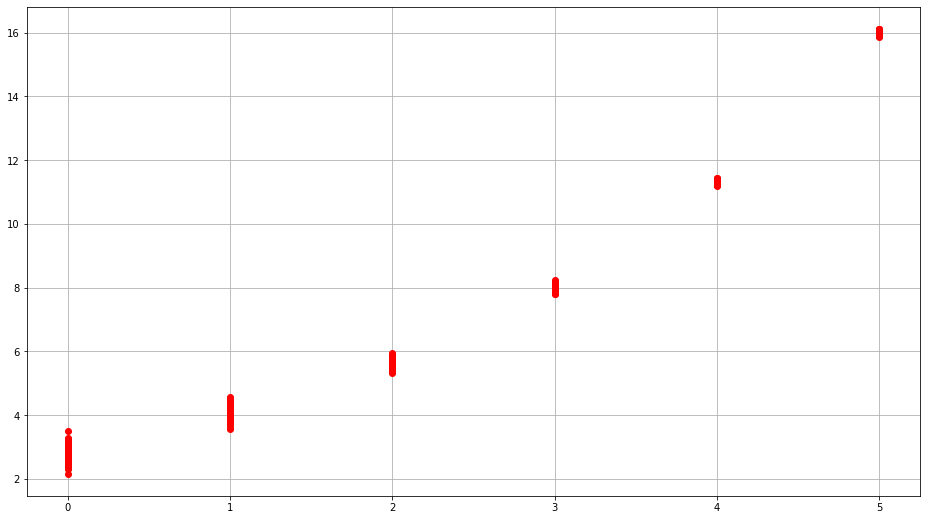

In [115]:
norm_list = []
for m in [8, 16, 32, 64, 128, 256]:
    temp_list = []
    for i in range(100):
        A = np.random.randn(m, m) / np.sqrt(m)
        temp_list.append(np.linalg.norm(A))
    norm_list.append(temp_list)

fig, ax = plt.subplots(figsize = (16,9))
plt.grid()
plt.plot(norm_list, 'ro')

### 4.3.c)

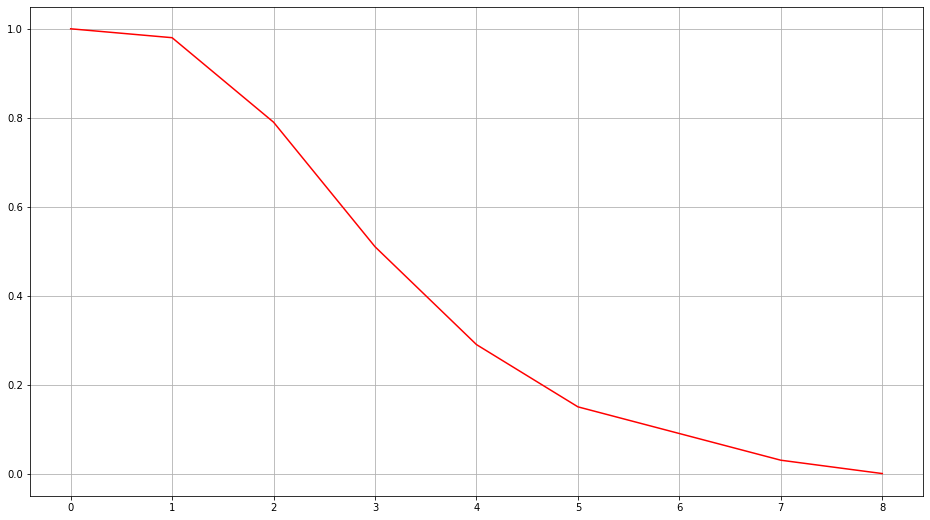

In [119]:
sing_list = []
for m in [8]:
    temp_list = []
    for i in range(100):
        A = np.random.randn(m, m) / np.sqrt(m)
        u, s, vh = np.linalg.svd(A)
        temp_list.append(min(s))
    sing_list.append(temp_list)

ratio_list = [(np.array(temp_list) <= 2**-i).sum() / len(temp_list) for i in range(1, 10)]

fig, ax = plt.subplots(figsize = (16,9))
plt.grid()
plt.plot(ratio_list, 'r-')

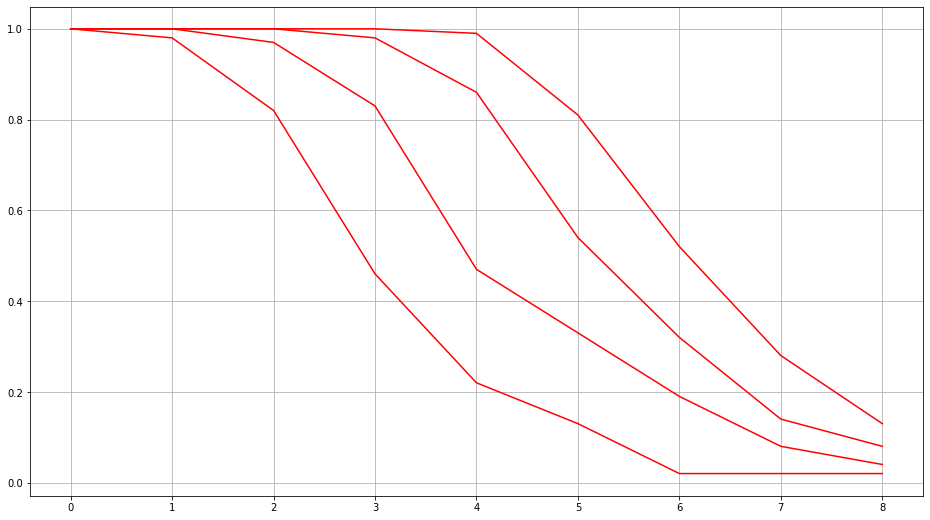

In [99]:
fig, ax = plt.subplots(figsize = (16,9))
plt.grid()

sing_list = []
for m in [8, 16, 32, 64]:
    temp_list = []
    for i in range(100):
        A = np.random.randn(m, m) / np.sqrt(m)
        u, s, vh = np.linalg.svd(A)
        temp_list.append(min(s))
    sing_list.append(temp_list)

for temp_list in sing_list:
    ratio_list = [(np.array(temp_list) <= 2**-i).sum() / len(temp_list) for i in range(1, 10)]
    plt.plot(ratio_list, 'r-')

### 4.3.d)

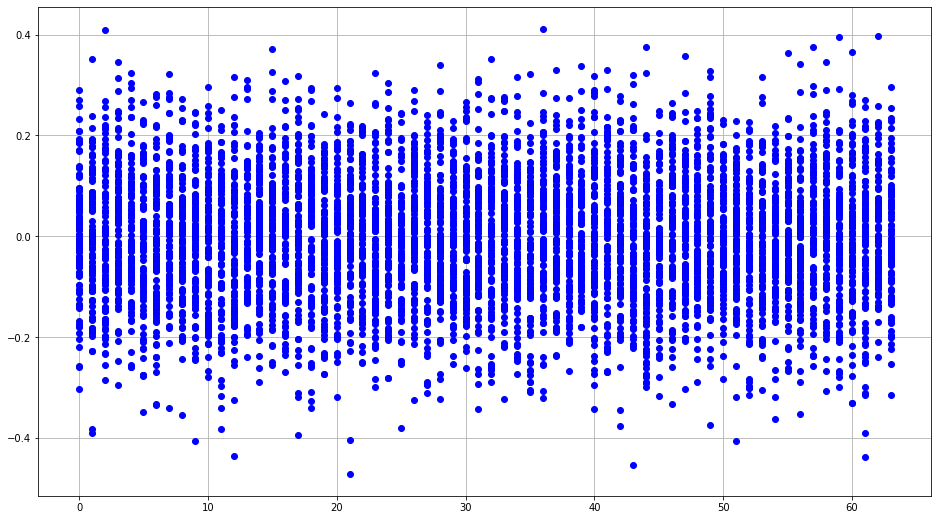

In [110]:
fig, ax = plt.subplots(figsize = (16,9))
plt.grid()

m = 64

for i in range(100):
    A = np.triu(np.random.randn(m, m) / np.sqrt(m))
    plt.plot(np.real(np.linalg.eigvals(A)), 'bo')

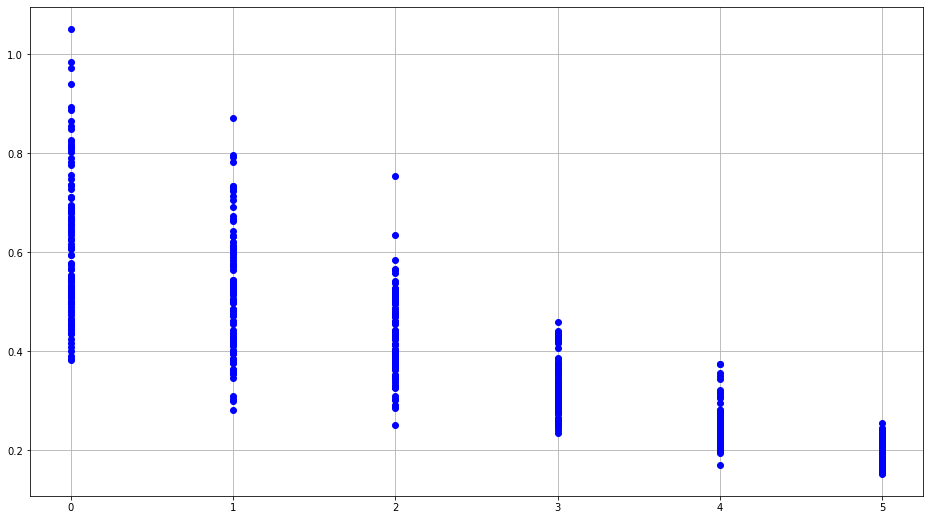

In [114]:
rad_list = []
for m in [8, 16, 32, 64, 128, 256]:
    temp_list = []
    for i in range(100):
        A = np.triu(np.random.randn(m, m) / np.sqrt(m))
        temp_list.append(max(np.abs(np.linalg.eigvals(A))))
    rad_list.append(temp_list)

fig, ax = plt.subplots(figsize = (16,9))
plt.grid()
plt.plot(rad_list, 'bo')

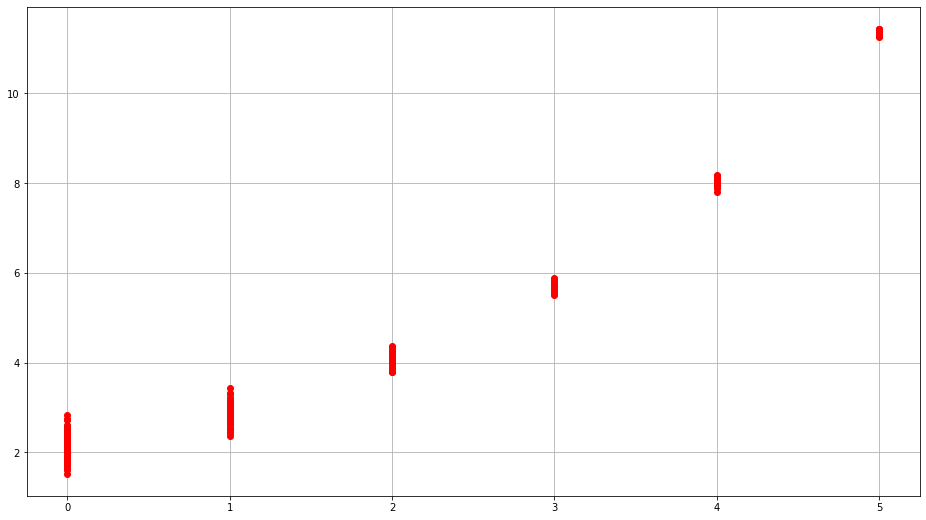

In [116]:
norm_list = []
for m in [8, 16, 32, 64, 128, 256]:
    temp_list = []
    for i in range(100):
        A = np.triu(np.random.randn(m, m) / np.sqrt(m))
        temp_list.append(np.linalg.norm(A))
    norm_list.append(temp_list)

fig, ax = plt.subplots(figsize = (16,9))
plt.grid()
plt.plot(norm_list, 'ro')

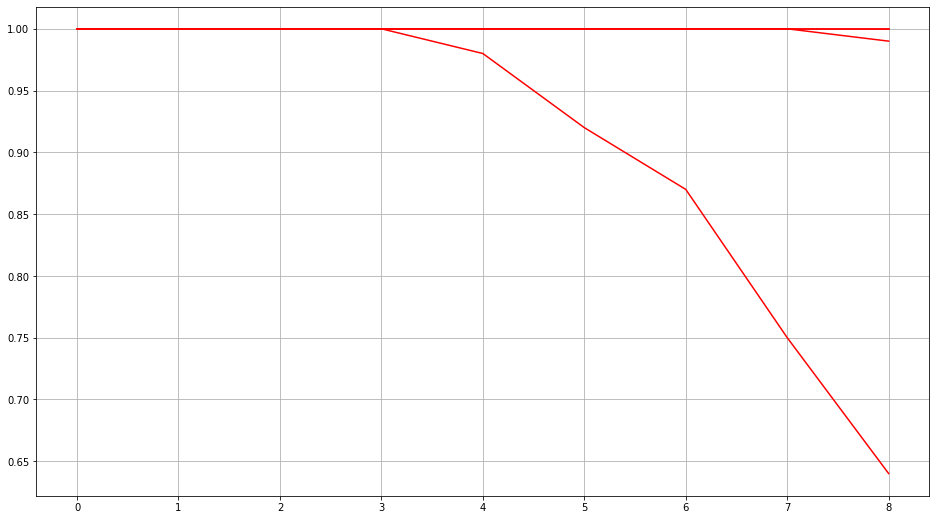

In [120]:
fig, ax = plt.subplots(figsize = (16,9))
plt.grid()

sing_list = []
for m in [8, 16, 32, 64]:
    temp_list = []
    for i in range(100):
        A = np.triu(np.random.randn(m, m) / np.sqrt(m))
        u, s, vh = np.linalg.svd(A)
        temp_list.append(min(s))
    sing_list.append(temp_list)

for temp_list in sing_list:
    ratio_list = [(np.array(temp_list) <= 2**-i).sum() / len(temp_list) for i in range(1, 10)]
    plt.plot(ratio_list, 'r-')

## 4.6.